# Packages

In [1]:
##uncomment to install libraries
!pip install gputil
!pip install psutil
!pip install humanize
!pip install pytorch-cinic

  Preparing metadata (setup.py) ... done
  Created wheel for gputil: filename=GPUtil-1.4.0-py3-none-any.whl size=7395 sha256=546948827f5551d5aaf2d1b368ce76f756c3177be7de43674d637d78c2b26869
  Stored in directory: /root/.cache/pip/wheels/a9/8a/bd/81082387151853ab8b6b3ef33426e98f5cbfebc3c397a9d4d0
Successfully built gputil
  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9657 sha256=4583670f229a8143a07dbcadc23e0252468c3f5cbbfeb51bbcd882b76fda0104
  Stored in directory: /root/.cache/pip/wheels/8b/f1/7f/5c94f0a7a505ca1c81cd1d9208ae2064675d97582078e6c769
Successfully built wget


In [2]:
# pytorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# torchvision
import torchvision
import torchvision.transforms.v2 as transforms

# plots
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns

# metrics
from sklearn.metrics import confusion_matrix

# utils
import time
import numpy as np
import os
import copy

##gpu
import psutil
import humanize
import GPUtil as GPU

In [3]:
##to find out about the information for computational requirements for the gpu

GPUs = GPU.getGPUs()

if GPUs:
    gpu = GPUs[0]  # only picked one gpu, we only had one available
    print(f"GPU Name: {gpu.name}")
    print(f"GPU Driver: {gpu.driver}")
    print(f"GPU Memory Total: {humanize.naturalsize(gpu.memoryTotal)}")
    print(f"GPU Memory Free: {humanize.naturalsize(gpu.memoryFree)}")
    print(f"GPU Memory Used: {humanize.naturalsize(gpu.memoryUsed)}")
else:
    print("No GPU available.")

# CPU information
print(f"\nCPU Cores: {psutil.cpu_count(logical=False)}")
print(f"CPU Threads: {psutil.cpu_count(logical=True)}")

GPU Name: Tesla T4
GPU Driver: 525.105.17
GPU Memory Total: 15.4 kB
GPU Memory Free: 15.1 kB
GPU Memory Used: 0 Bytes

CPU Cores: 1
CPU Threads: 2


In [4]:
!nvidia-smi

Mon Nov 20 22:29:13 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   61C    P8    10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [5]:

from pytorch_cinic.dataset import CINIC10

# Data

In [6]:
!wget https://datashare.is.ed.ac.uk/bitstream/handle/10283/3192/CINIC-10.tar.gz

--2023-11-20 22:29:13--  https://datashare.is.ed.ac.uk/bitstream/handle/10283/3192/CINIC-10.tar.gz
Resolving datashare.is.ed.ac.uk (datashare.is.ed.ac.uk)... 129.215.67.128
Connecting to datashare.is.ed.ac.uk (datashare.is.ed.ac.uk)|129.215.67.128|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://datashare.ed.ac.uk/bitstream/handle/10283/3192/CINIC-10.tar.gz [following]
--2023-11-20 22:29:14--  https://datashare.ed.ac.uk/bitstream/handle/10283/3192/CINIC-10.tar.gz
Resolving datashare.ed.ac.uk (datashare.ed.ac.uk)... 129.215.67.172
Connecting to datashare.ed.ac.uk (datashare.ed.ac.uk)|129.215.67.172|:443... connected.
HTTP request sent, awaiting response... 200 200
Length: 687544992 (656M) [application/gzip]
Saving to: ‘CINIC-10.tar.gz’

CINIC-10.tar.gz     100%[===================>] 655.69M  15.4MB/s    in 31s     

2023-11-20 22:29:45 (21.4 MB/s) - ‘CINIC-10.tar.gz’ saved [687544992/687544992]



In [7]:

if os.path.exists("/content/data/CINIC-10.tar.gz") == False:
    download = True
else:
    download = False

CINIC10(root="/content/data", download=True, transform=transforms.ToTensor())

# dataset_train = "/content/data/data/train"
# dataset_train = "/content/data/data/test"

Folder /content/data does not exist


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/_deprecated.py:43: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


Dataset CINIC10
    Number of datapoints: 90000
    Root location: /content/data
    Split: train
    StandardTransform
Transform: ToTensor()

In [8]:
cinic_directory = '/content/data/'
cinic_mean = [0.47889522, 0.47227842, 0.43047404]
cinic_std = [0.24205776, 0.23828046, 0.25874835]
dataset_train = torch.utils.data.DataLoader(
    torchvision.datasets.ImageFolder(cinic_directory + '/train',
    	transform=transforms.Compose([transforms.ToTensor(),
        transforms.Normalize(mean=cinic_mean,std=cinic_std)])),
    batch_size=128, shuffle=True)

dataset_test = torch.utils.data.DataLoader(
    torchvision.datasets.ImageFolder(cinic_directory + '/test',
    	transform=transforms.Compose([transforms.ToTensor(),
        transforms.Normalize(mean=cinic_mean,std=cinic_std)])),
    batch_size=128, shuffle=True)

dataset_valid = torch.utils.data.DataLoader(
    torchvision.datasets.ImageFolder(cinic_directory + '/valid',
    	transform=transforms.Compose([transforms.ToTensor(),
        transforms.Normalize(mean=cinic_mean,std=cinic_std)])),
    batch_size=128, shuffle=True)

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/_deprecated.py:43: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


In [9]:
# CINIC10_mean = np.mean(cinic_train / 255.0, axis=(0, 1, 2))
# CINIC10_std = np.std(cinic_test / 255.0, axis=(0, 1, 2))
# transform = transforms.Compose(
#     [
#         # first cast the data to a pytorch tensor
#         transforms.ToTensor(),
#         # then define mean and std for the normalization (RMK: for each channel)
#         # output[channel] = (input[channel] - mean[channel]) / std[channel]
#         transforms.Normalize(mean=CINIC10_mean, std=CINIC10_std),
#     ]
# )

# if os.path.exists("/content/CINIC-10.tar.gz") == False:
#     download = True
# else:
#     download = False

# dataset_train = torchvision.datasets.CIFAR10(
#     root="./data", train=True, download=download, transform=transform
# )
# dataset_test = torchvision.datasets.CIFAR10(
#     root="./data", train=False, download=download, transform=transform
# )

classes = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]
print(f"length of training dataset {len(dataset_train)}")
print(f"length of test dataset {len(dataset_test)}")


length of training dataset 704
length of test dataset 704


## Training dataset split

In [10]:
torch.manual_seed(42)
# This just splits the indices into two subsets basically
train_subset, val_subset = torch.utils.data.random_split(dataset_train, [0.8, 0.2])

## Data loaders

In [11]:
batch_size = 128  # hyperparameter
# trainloader = torch.utils.data.DataLoader(
#     train_subset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True
# )
# valloader = torch.utils.data.DataLoader(
#     val_subset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True
# )
# testloader = torch.utils.data.DataLoader(
#     dataset_test, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True
# )

# Model

In [12]:
class VGG13(nn.Module):
    def __init__(self, num_classes, batch_norm=False, dropout=False):
        super(VGG13, self).__init__()
        self.batch_norm = batch_norm

        self.conv_layers = nn.ModuleList(
            [
                nn.Conv2d(3, 64, kernel_size=3, padding=1),
                nn.Conv2d(64, 64, kernel_size=3, padding=1),
                nn.Conv2d(64, 128, kernel_size=3, padding=1),
                nn.Conv2d(128, 128, kernel_size=3, padding=1),
                nn.Conv2d(128, 256, kernel_size=3, padding=1),
                nn.Conv2d(256, 256, kernel_size=3, padding=1),
                nn.Conv2d(256, 512, kernel_size=3, padding=1),
                nn.Conv2d(512, 512, kernel_size=3, padding=1),
                nn.Conv2d(512, 512, kernel_size=3, padding=1),
                nn.Conv2d(512, 512, kernel_size=3, padding=1),
            ]
        )

        self.pool_layers = nn.ModuleList(
            [
                nn.Identity(),
                nn.MaxPool2d(kernel_size=2, stride=2),
                nn.Identity(),
                nn.MaxPool2d(kernel_size=2, stride=2),
                nn.Identity(),
                nn.MaxPool2d(kernel_size=2, stride=2),
                nn.Identity(),
                nn.MaxPool2d(kernel_size=2, stride=2),
                nn.Identity(),
                nn.MaxPool2d(kernel_size=2, stride=2),
            ]
        )

        if self.batch_norm:
            self.norm_layers = nn.ModuleList(
                [
                    nn.BatchNorm2d(64),
                    nn.BatchNorm2d(64),
                    nn.BatchNorm2d(128),
                    nn.BatchNorm2d(128),
                    nn.BatchNorm2d(256),
                    nn.BatchNorm2d(256),
                    nn.BatchNorm2d(512),
                    nn.BatchNorm2d(512),
                    nn.BatchNorm2d(512),
                    nn.BatchNorm2d(512),
                ]
            )
        else:
            self.norm_layers = nn.ModuleList(
                [
                    nn.Identity(),
                    nn.Identity(),
                    nn.Identity(),
                    nn.Identity(),
                    nn.Identity(),
                    nn.Identity(),
                    nn.Identity(),
                    nn.Identity(),
                    nn.Identity(),
                    nn.Identity(),
                ]
            )

        if dropout:
            self.classifier = nn.Sequential(
                # 1st block
                nn.Linear(512 * 1 * 1, 4096),
                nn.ReLU(inplace=True),
                nn.Dropout(),
                # 2nd block
                nn.Linear(4096, 4096),
                nn.ReLU(inplace=True),
                nn.Dropout(),
                # output
                nn.Linear(4096, num_classes),
            )
        else:
            self.classifier = nn.Sequential(
                # 1st block
                nn.Linear(512 * 1 * 1, 4096),
                nn.ReLU(inplace=True),
                # 2nd block
                nn.Linear(4096, 4096),
                nn.ReLU(inplace=True),
                # output
                nn.Linear(4096, num_classes),
            )

    def forward(self, x):
        for conv, norm, pool in zip(
            self.conv_layers, self.norm_layers, self.pool_layers
        ):
            x = conv(x)
            x = norm(x)
            F.relu(x, inplace=True)
            x = pool(x)

        # flatten
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

# Training

### Utils

In [13]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cuda:0


In [14]:
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0, restore_best_weights=True):
        self.patience = patience
        self.min_delta = min_delta  # minimum improvement to reset patience
        self.restore_best_weights = restore_best_weights
        self.best_model = None
        self.best_loss = None
        self.counter = 0
        self.status = ""

    def __call__(self, model, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
            self.best_model = copy.deepcopy(model)
        elif self.best_loss - val_loss > self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
            self.best_model.load_state_dict(model.state_dict())
        elif self.best_loss - val_loss < self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.status = f"Stopped on {self.counter}"
                if self.restore_best_weights:
                    model.load_state_dict(self.best_model.state_dict())
                return True
        self.status = f"{self.counter}/{self.patience}"
        return False

In [15]:
#to check memory usage and gpu status
!nvidia-smi

Mon Nov 20 22:30:38 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   55C    P8    10W /  70W |      3MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Train loop

In [ ]:
def train_model(
    model,
    n_epochs,
    trainloader,
    valloader,
    optimizer,
    loss_fn,
    early_stopping=False,
    verbose=True,
):
    n_records = 5
    check_train = len(trainloader) // n_records
    check_val = len(valloader) // n_records

    training_loss = []
    training_accuracy = []
    validation_loss = []
    validation_accuracy = []

    if early_stopping:
        early_stop = EarlyStopping(patience=5, restore_best_weights=False)

    for epoch in range(n_epochs):
        # train the model
        correct = 0
        total = 0
        running_loss = 0
        tot_samples = 0
        model.train()
        for i, (data, target) in enumerate(trainloader):
            # move tensors to GPU if CUDA is available
            data = data.to(device)
            target = target.to(device)
            # forward pass
            output = model(data)
            # calculate the batch loss
            loss = loss_fn(output, target)
            # backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            tot_samples += 1
            if verbose and (i + 1) % check_train == 0:
                _, pred = torch.max(output, dim=1)
                correct += (pred == target).sum().item()
                total += batch_size
                accuracy = correct / total
                training_loss.append(running_loss / tot_samples)
                training_accuracy.append(accuracy)
                print(
                    f"Epoch {epoch + 1}"
                    + f"\tTraining loss: {loss.item():.6f}"
                    + f"\tRunning loss: {running_loss / tot_samples:.6f}"
                    + f"\tTraining partial incremental accuracy: {accuracy * 100:.2f}"
                )
                running_loss = 0
                tot_samples = 0
        # validate the model
        with torch.no_grad():
            model.eval()
            correct = 0
            total = 0
            running_loss = 0
            tot_samples = 0
            for i, (data, target) in enumerate(valloader):
                # move tensors to GPU if CUDA is available
                data = data.to(device)
                target = target.to(device)
                # forward pass
                output = model(data)
                _, pred = torch.max(output, dim=1)
                correct += (pred == target).sum().item()
                total += batch_size
                loss = loss_fn(output, target).item()
                running_loss += loss
                tot_samples += 1
                if verbose and (i + 1) % check_val == 0:
                    # calculate the batch loss
                    accuracy = correct / total
                    validation_loss.append(running_loss / tot_samples)
                    validation_accuracy.append(accuracy)
                    print(
                        f"Epoch {epoch + 1}"
                        + f"\tValidation loss: {loss:.6f}"
                        + f"\tRunning loss: {running_loss / tot_samples:.6f}"
                        + f"\tAccuracy: {accuracy * 100:.2f}"
                    )
                    running_loss = 0
                    tot_samples = 0

        if early_stopping and early_stop(model, validation_loss[-1]):
            print(f"Stopped trained at epoch {epoch + 1}")
            if early_stop.restore_best_weights:
                print(
                    f"Restored model trained at epoch {epoch + 1 - early_stop.counter}"
                )
            break

    return (
        training_loss,
        training_accuracy,
        validation_loss,
        validation_accuracy,
    )

In [ ]:
torch.manual_seed(42)
vgg = VGG13(num_classes=10)
# print(vgg)
# print(check_train)
# print(check_val)

optimizer = optim.Adam(
    vgg.parameters(),
    lr=0.0005,
)

loss_fn = nn.CrossEntropyLoss()

n_epochs = 30

vgg = vgg.to(device)

start = time.time()
(
    training_loss,
    training_accuracy,
    validation_loss,
    validation_accuracy,
) = train_model(
    vgg,
    n_epochs,
    dataset_train,
    dataset_valid,
    optimizer,
    loss_fn,
    early_stopping=True,
    verbose=True,
)
end = time.time()
print(f"Training took {end - start:.2f} seconds")

Epoch 1	Training loss: 2.063729	Running loss: 2.162747	Training partial incremental accuracy: 17.19
Epoch 1	Training loss: 1.919864	Running loss: 1.936131	Training partial incremental accuracy: 21.88
Epoch 1	Training loss: 1.948385	Running loss: 1.817916	Training partial incremental accuracy: 22.40
Epoch 1	Training loss: 1.641044	Running loss: 1.668540	Training partial incremental accuracy: 25.78
Epoch 1	Training loss: 1.349481	Running loss: 1.589382	Training partial incremental accuracy: 29.69
Epoch 1	Validation loss: 1.464168	Running loss: 1.520787	Accuracy: 38.58
Epoch 1	Validation loss: 1.477318	Running loss: 1.527432	Accuracy: 38.73
Epoch 1	Validation loss: 1.550821	Running loss: 1.517616	Accuracy: 38.67
Epoch 1	Validation loss: 1.532364	Running loss: 1.520565	Accuracy: 38.72
Epoch 1	Validation loss: 1.543915	Running loss: 1.521499	Accuracy: 38.73
Epoch 2	Training loss: 1.431885	Running loss: 1.506952	Training partial incremental accuracy: 39.06
Epoch 2	Training loss: 1.310191	Run

### Test

In [ ]:
# test accuracy
vgg.eval()
correct = 0
total = 0

start = time.time()
with torch.no_grad():
    for data, target in dataset_test:
        # move tensors to GPU if CUDA is available
        data = data.to(device)
        target = target.to(device)
        # forward pass
        output = vgg(data)
        _, pred = torch.max(output, dim=1)
        total += target.size(0)
        correct += (pred == target).sum().item()
end = time.time()

print(f"Test accuracy: {correct / total * 100:.2f}%")
print(f"Test took {end - start:.2f} seconds")

Test accuracy: 66.87%
Test took 62.92 seconds


### Inference time test

In [ ]:
vgg.eval()
test_iter = iter(dataset_test )
np.random.seed(666)
for i in range(np.random.randint(0, len(dataset_test ))):
    img_batch, target_batch = next(test_iter)
img = img_batch[0]
target = target_batch[0]
img = img.unsqueeze(0).to(device)

with torch.no_grad():
    start = time.time()
    output = vgg(img)
    end = time.time()
    print(f"Inference time {end - start:.8f} seconds")
    print(f"Output: {output}")
    _, pred = torch.max(output, dim=1)
    print(f"Prediction: {classes[pred]}")
    print(f"Target: {classes[target]}")

Inference time 0.00144649 seconds
Output: tensor([[-15.3803, -16.3148,  -0.7046,   1.4282,   7.7985,   2.6908,  -4.1165,
          -2.7665, -14.3311, -13.3858]], device='cuda:0')
Prediction: deer
Target: deer


In [ ]:
#to check memory usage and gpu status
!nvidia-smi


Mon Nov 20 20:51:45 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   75C    P0    29W /  70W |   2167MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Learning curves

Text(0, 0.5, 'Loss')

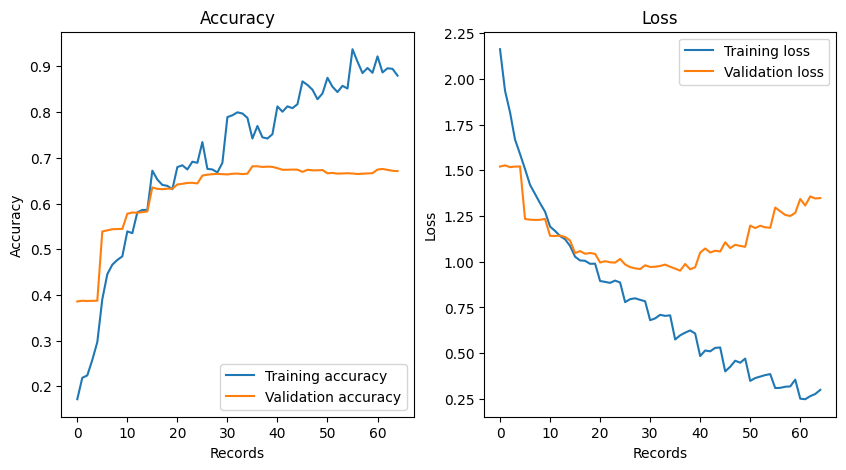

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].plot(training_accuracy, label="Training accuracy")
axs[0].plot(validation_accuracy, label="Validation accuracy")
axs[0].legend(loc="lower right")
axs[0].set_title("Accuracy")
axs[0].set_xlabel("Records")
axs[0].set_ylabel("Accuracy")

axs[1].plot(training_loss, label="Training loss")
axs[1].plot(validation_loss, label="Validation loss")
axs[1].legend(loc="upper right")
axs[1].set_title("Loss")
axs[1].set_xlabel("Records")
axs[1].set_ylabel("Loss")

### Confusion matrix

In [ ]:
def compute_confusion_matrix(model, dataset_test):
    model.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
        for data, target in dataset_test:
            # move tensors to GPU if CUDA is available
            data = data.to(device)
            target = target.to(device)
            # forward pass
            output = model(data)
            _, pred = torch.max(output, dim=1)
            y_true.append(target.cpu().numpy())
            y_pred.append(pred.cpu().numpy())

    y_true = np.concatenate(y_true)
    y_pred = np.concatenate(y_pred)

    return confusion_matrix(y_true, y_pred, normalize="true") * 100

In [ ]:
conf_mat = compute_confusion_matrix(vgg, dataset_test )
print(conf_mat)

[[76.24444444  1.32222222  5.47777778  0.72222222  2.1         0.64444444
   0.47777778  1.14444444  9.21111111  2.65555556]
 [ 2.1        75.75555556  0.68888889  0.55555556  0.88888889  0.73333333
   0.5         0.58888889  5.2        12.98888889]
 [ 3.93333333  0.35555556 63.37777778  6.55555556  8.1         5.83333333
   7.9         1.04444444  2.52222222  0.37777778]
 [ 0.77777778  0.73333333  7.22222222 50.97777778  8.53333333 19.22222222
   8.2         1.88888889  1.63333333  0.81111111]
 [ 1.57777778  0.32222222  7.04444444  7.57777778 62.94444444  9.73333333
   2.77777778  5.93333333  1.42222222  0.66666667]
 [ 0.86666667  0.66666667  6.95555556 18.1        12.92222222 49.22222222
   2.48888889  6.35555556  1.37777778  1.04444444]
 [ 0.7         0.3         7.18888889  7.92222222  3.05555556  1.75555556
  78.01111111  0.15555556  0.73333333  0.17777778]
 [ 1.35555556  0.43333333  2.12222222  2.12222222 12.47777778  8.5
   0.36666667 69.36666667  1.51111111  1.74444444]
 [ 7.28

<Axes: >

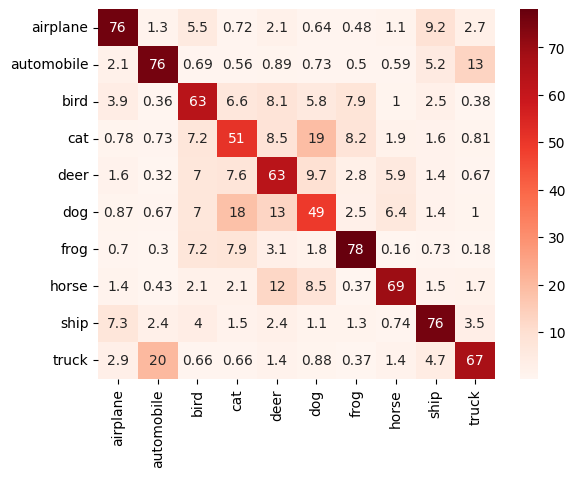

In [ ]:
sns.heatmap(
    conf_mat, annot=True, cmap=cm.Reds, xticklabels=classes, yticklabels=classes
)

# Early exit

## B-NET

In [ ]:
#to check memory usage and gpu status
!nvidia-smi

Mon Nov 20 20:52:55 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   77C    P0    29W /  70W |   2167MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Early exit decision criterion

In [ ]:
def entropy(x):
    p = F.softmax(x.detach(), dim=1)
    H = -torch.mean(p * torch.log(p + 1e-8), dim=1)
    return H

### Model

In [ ]:
def create_early_exit(in_shape, in_channels, num_classes):
    return nn.Sequential(
        # Convolution
        nn.Conv2d(in_channels, 128, kernel_size=3, padding=1),
        nn.ReLU(inplace=True),
        # Global average pooling
        # nn.AdaptiveAvgPool2d(1),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Flatten(),
        # classifier
        nn.Linear(128 * in_shape // 2 * in_shape // 2, num_classes),
    )

In [ ]:
class BVGG13(nn.Module):
    def __init__(self, num_classes, batch_norm=False, dropout=False):
        super(BVGG13, self).__init__()
        self.batch_norm = batch_norm
        self.dropout = dropout
        self.set_exit_threshold(0.0)

        self.conv_layers = nn.ModuleList(
            [
                nn.Conv2d(3, 64, kernel_size=3, padding=1),
                nn.Conv2d(64, 64, kernel_size=3, padding=1),
                nn.Conv2d(64, 128, kernel_size=3, padding=1),
                nn.Conv2d(128, 128, kernel_size=3, padding=1),
                nn.Conv2d(128, 256, kernel_size=3, padding=1),
                nn.Conv2d(256, 256, kernel_size=3, padding=1),
                nn.Conv2d(256, 512, kernel_size=3, padding=1),
                nn.Conv2d(512, 512, kernel_size=3, padding=1),
                nn.Conv2d(512, 512, kernel_size=3, padding=1),
                nn.Conv2d(512, 512, kernel_size=3, padding=1),
            ]
        )

        self.pool_layers = nn.ModuleList(
            [
                nn.Identity(),
                nn.MaxPool2d(kernel_size=2, stride=2),
                nn.Identity(),
                nn.MaxPool2d(kernel_size=2, stride=2),
                nn.Identity(),
                nn.MaxPool2d(kernel_size=2, stride=2),
                nn.Identity(),
                nn.MaxPool2d(kernel_size=2, stride=2),
                nn.Identity(),
                nn.MaxPool2d(kernel_size=2, stride=2),
            ]
        )

        if self.batch_norm:
            self.norm_layers = nn.ModuleList(
                [
                    nn.BatchNorm2d(64),
                    nn.BatchNorm2d(64),
                    nn.BatchNorm2d(128),
                    nn.BatchNorm2d(128),
                    nn.BatchNorm2d(256),
                    nn.BatchNorm2d(256),
                    nn.BatchNorm2d(512),
                    nn.BatchNorm2d(512),
                    nn.BatchNorm2d(512),
                    nn.BatchNorm2d(512),
                ]
            )
        else:
            self.norm_layers = nn.ModuleList(
                [
                    nn.Identity(),
                    nn.Identity(),
                    nn.Identity(),
                    nn.Identity(),
                    nn.Identity(),
                    nn.Identity(),
                    nn.Identity(),
                    nn.Identity(),
                    nn.Identity(),
                    nn.Identity(),
                ]
            )

        if self.dropout:
            self.classifier = nn.Sequential(
                # 1st block
                nn.Linear(512 * 1 * 1, 4096),
                nn.ReLU(inplace=True),
                nn.Dropout(),
                # 2nd block
                nn.Linear(4096, 4096),
                nn.ReLU(inplace=True),
                nn.Dropout(),
                # output
                nn.Linear(4096, num_classes),
            )
        else:
            self.classifier = nn.Sequential(
                # 1st block
                nn.Linear(512 * 1 * 1, 4096),
                nn.ReLU(inplace=True),
                # 2nd block
                nn.Linear(4096, 4096),
                nn.ReLU(inplace=True),
                # output
                nn.Linear(4096, num_classes),
            )

        self.early_exits = nn.ModuleList(
            [
                create_early_exit(32, 64, num_classes),
                create_early_exit(16, 64, num_classes),
                create_early_exit(16, 128, num_classes),
                create_early_exit(8, 128, num_classes),
                create_early_exit(8, 256, num_classes),
                create_early_exit(4, 256, num_classes),
                create_early_exit(4, 512, num_classes),
                create_early_exit(2, 512, num_classes),
                create_early_exit(2, 512, num_classes),
            ]
        )

    def forward(self, x, inference=False):
        out = []
        e = 0
        for conv, norm, pool in zip(
            self.conv_layers, self.norm_layers, self.pool_layers
        ):
            x = conv(x)
            x = norm(x)
            F.relu(x, inplace=True)
            x = pool(x)
            if e < len(self.early_exits):
                x_ee = self.early_exits[e](x)
                out.append(x_ee)
                e += 1
            if inference:
                # x is a single image, otherwise we would have to loop over the batch dimension
                H = entropy(x_ee)
                if torch.less(H, self.exit_threshold):
                    return x_ee, H, e

        # flatten
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        out.append(x)
        if inference:
            return x, H, e
        return out

    def set_exit_threshold(self, exit_threshold):
        self.exit_threshold = torch.tensor(exit_threshold)

### Custom loss function

In [24]:
class JointCrossEntropy(nn.Module):
    def __init__(self):
        super(JointCrossEntropy, self).__init__()
        self.cross_entropy = nn.CrossEntropyLoss()

    def forward(self, outputs, targets):
        loss = 0
        for output in outputs:
            loss += self.cross_entropy(output, targets)
        return loss

In [25]:
#to check memory usage and gpu status
!nvidia-smi

Mon Nov 20 22:31:18 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   53C    P8    10W /  70W |      3MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Training loop

In [ ]:
def train_model_ee(
    model,
    n_epochs,
    dataset_train,
    dataset_valid,
    optimizer,
    loss_fn,
    early_stopping=False,
    verbose=True,
):
    n_records = 5
    check_train = len(dataset_train) // n_records
    check_val = len(dataset_valid) // n_records

    training_loss = []
    training_accuracy = []
    validation_loss = []
    validation_accuracy = []

    if early_stopping:
        early_stop = EarlyStopping(patience=5, restore_best_weights=False)

    for epoch in range(n_epochs):
        # train the model
        correct = np.zeros(len(model.early_exits) + 1)
        total = 0
        running_loss = 0
        tot_samples = 0
        model.train()
        for i, (data, target) in enumerate(dataset_train):
            # move tensors to GPU if CUDA is available
            data = data.to(device)
            target = target.to(device)
            # forward pass
            output = model(data)
            # calculate the batch loss
            loss = loss_fn(output, target)
            # backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            tot_samples += 1
            if verbose and (i + 1) % check_train == 0:
                print_str = f"Epoch {epoch + 1}\tTraining loss: {running_loss / tot_samples:.4f}"
                training_loss.append(running_loss / tot_samples)
                total += batch_size
                for i, out in enumerate(output):
                    _, pred = torch.max(out, dim=1)
                    correct[i] += (pred == target).sum().item()
                accuracy = correct / total
                training_accuracy.append(accuracy)
                accuracy = np.round(accuracy * 100, 2)
                print_str += f"\tAccuracy: {accuracy.__str__()}"
                running_loss = 0
                tot_samples = 0
                print(print_str)
        # validate the model
        with torch.no_grad():
            model.eval()
            correct = np.zeros(len(model.early_exits) + 1)
            total = 0
            running_loss = 0
            tot_samples = 0
            for i, (data, target) in enumerate(dataset_valid):
                # move tensors to GPU if CUDA is available
                data = data.to(device)
                target = target.to(device)
                # forward pass
                output = model(data)
                loss = loss_fn(output, target).item()
                running_loss += loss
                tot_samples += 1
                if verbose and (i + 1) % check_val == 0:
                    print_str = f"Epoch {epoch + 1}\tValidation loss: {running_loss / tot_samples:.4f}"
                    validation_loss.append(running_loss / tot_samples)
                    total += batch_size
                    for i, out in enumerate(output):
                        _, pred = torch.max(out, dim=1)
                        correct[i] += (pred == target).sum().item()
                    accuracy = correct / total
                    validation_accuracy.append(accuracy)
                    accuracy = np.round(accuracy * 100, 2)
                    print_str += f"\tAccuracy: {accuracy.__str__()}"
                    running_loss = 0
                    tot_samples = 0
                    print(print_str)

        if early_stopping and early_stop(model, validation_loss[-1]):
            print(f"Stopped trained at epoch {epoch + 1}")
            if early_stop.restore_best_weights:
                print(
                    f"Restored model trained at epoch {epoch + 1 - early_stop.counter}"
                )
            break

    return (
        training_loss,
        training_accuracy,
        validation_loss,
        validation_accuracy,
    )

In [ ]:
torch.manual_seed(42)
bvgg = BVGG13(num_classes=10)
# print(vgg)
# print(check_train)
# print(check_val)

optimizer = optim.Adam(
    bvgg.parameters(),
    lr=0.0005,
)

loss_fn = JointCrossEntropy()

n_epochs = 30

bvgg.to(device)

start = time.time()
(
    training_loss,
    training_accuracy,
    validation_loss,
    validation_accuracy,
) = train_model_ee(
    bvgg,
    n_epochs,
    dataset_train,
    dataset_valid,
    optimizer,
    loss_fn,
    early_stopping=True,
    verbose=True,
)
end = time.time()
print(f"Training took {end - start:.2f} seconds")

Epoch 1	Training loss: 19.3368	Accuracy: [41.41 35.16 37.5  35.16 35.94 37.5  37.5  32.81 28.91 25.  ]
Epoch 1	Training loss: 16.6728	Accuracy: [48.83 44.14 44.92 42.58 40.62 42.19 42.19 38.67 35.94 33.2 ]
Epoch 1	Training loss: 15.4861	Accuracy: [51.3  47.66 47.4  44.53 41.67 41.93 41.93 38.8  37.24 35.68]
Epoch 1	Training loss: 14.2244	Accuracy: [52.93 49.8  49.02 46.09 44.14 44.14 43.36 40.82 39.06 37.89]
Epoch 1	Training loss: 13.5639	Accuracy: [54.37 51.72 50.62 47.81 46.56 46.41 45.47 43.59 41.72 40.16]
Epoch 1	Validation loss: 13.1362	Accuracy: [53.91 57.81 57.03 57.03 57.03 57.03 50.78 51.56 49.22 47.66]
Epoch 1	Validation loss: 13.0707	Accuracy: [55.08 58.2  57.42 55.47 57.42 55.08 51.95 53.12 51.17 50.39]
Epoch 1	Validation loss: 13.0665	Accuracy: [54.69 57.03 55.99 53.12 54.69 53.91 51.56 53.39 50.78 49.48]
Epoch 1	Validation loss: 13.0129	Accuracy: [54.1  56.05 56.25 51.76 53.32 53.52 50.59 51.17 49.02 47.27]
Epoch 1	Validation loss: 13.1250	Accuracy: [53.91 56.56 55.62 51.

### Test data

In [ ]:
# test accuracy
bvgg.eval()

with torch.no_grad():
    for i in range(10):
        correct = 0
        total = 0
        start = time.time()
        for data, target in dataset_test:
            # move tensors to GPU if CUDA is available
            data = data.to(device)
            target = target.to(device)
            # forward pass
            output = bvgg(data, inference=False)
            # Test accuracy on the final exit
            _, pred = torch.max(output[i], dim=1)
            correct += (pred == target).sum().item()
            total += target.size(0)
        end = time.time()
        print(f"Exit {i+1} test accuracy: {correct / total * 100:.2f}%")
        print(f"Test took {end - start:.2f} seconds")
avg_acc = correct / total
print(f"the average test accuracy is {100*avg_acc}")

Exit 1 test accuracy: 55.99%
Test took 72.54 seconds
Exit 2 test accuracy: 63.41%
Test took 70.38 seconds
Exit 3 test accuracy: 66.96%
Test took 70.04 seconds
Exit 4 test accuracy: 68.77%
Test took 70.79 seconds
Exit 5 test accuracy: 69.86%
Test took 71.02 seconds
Exit 6 test accuracy: 70.06%
Test took 71.06 seconds
Exit 7 test accuracy: 70.12%
Test took 70.06 seconds
Exit 8 test accuracy: 69.67%
Test took 68.82 seconds
Exit 9 test accuracy: 69.52%
Test took 70.27 seconds
Exit 10 test accuracy: 69.27%
Test took 70.07 seconds
the average test accuracy is 69.27111111111111


### Inference time

In [ ]:
bvgg.eval()
test_iter = iter(dataset_test)
np.random.seed(666)
for i in range(np.random.randint(0, len(dataset_test))):
    img_batch, target_batch = next(test_iter)
img_idx = np.random.randint(batch_size)
img = img_batch[img_idx]
target = target_batch[img_idx]
img = img.unsqueeze(0).to(device)

bvgg.set_exit_threshold(0.1)
with torch.no_grad():
    start = time.time()
    output, H, e = bvgg(img, inference=True)
    end = time.time()
    print(f"Inference time {end - start:.8f} seconds")
    print(f"Exit: {e+1}")
    print(f"Entropy: {H.detach().cpu()}")
    print(f"Output: {output.detach().cpu()}")
    _, pred = torch.max(output, dim=1)
    print(f"Prediction: {classes[pred]}")
    print(f"Target: {classes[target]}")

Inference time 0.01760936 seconds
Exit: 7
Entropy: tensor([0.0961])
Output: tensor([[-9.6251, -8.5753, -2.9640,  0.9981,  1.4434, -1.5737, -4.9414, -2.5178,
         -1.8881, -5.7714]])
Prediction: deer
Target: dog


In [ ]:
#to check memory usage and gpu status
!nvidia-smi

Mon Nov 20 21:32:57 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   61C    P0    27W /  70W |   2841MiB / 15360MiB |      1%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Learning curves.

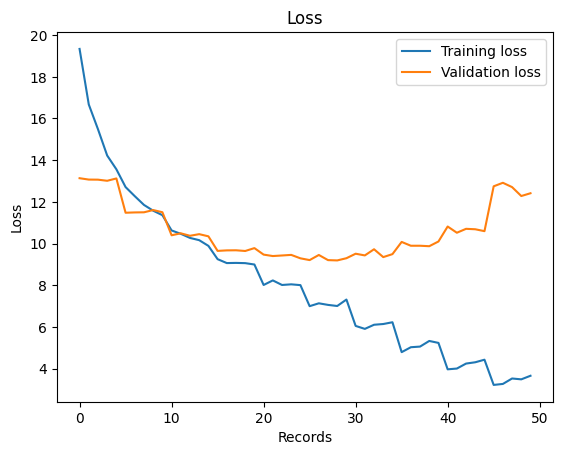

In [ ]:
plt.plot(training_loss, label="Training loss")
plt.plot(validation_loss, label="Validation loss")
plt.legend(loc="upper right")
plt.title("Loss")
plt.xlabel("Records")
plt.ylabel("Loss")
plt.show()

(50, 10)


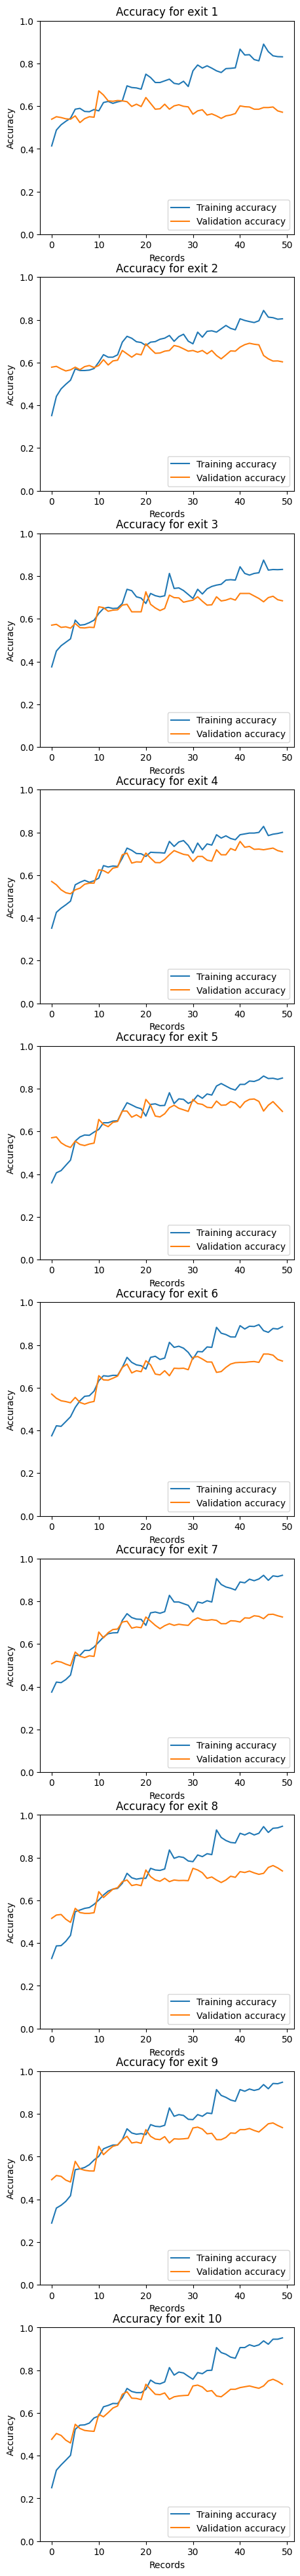

In [ ]:
training_accuracy = np.array(training_accuracy)
validation_accuracy = np.array(validation_accuracy)
print(training_accuracy.shape)
fig, axs = plt.subplots(10, 1, figsize=(5, 50))
axs = axs.flatten()
for i in range(10):
    axs[i].plot(training_accuracy[:, i], label="Training accuracy")
    axs[i].plot(validation_accuracy[:, i], label="Validation accuracy")
    axs[i].legend(loc="lower right")
    axs[i].set_title(f"Accuracy for exit {i + 1}")
    axs[i].set_xlabel("Records")
    axs[i].set_ylabel("Accuracy")
    axs[i].set_ylim([0, 1])

## Proposed algorithm for training

In [16]:
#to check memory usage and gpu status
!nvidia-smi

Mon Nov 20 22:30:38 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   55C    P8    10W /  70W |      3MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Early exit decision criterion.

Based on:
- Entropy of the logits;
- Probability of the guess.

In [17]:
def entropy(x):
    p = F.softmax(x, dim=1)
    H = -torch.mean(p * torch.log(p + 1e-8), dim=1)
    return H

In [18]:
def find_max_prob(x):
    p = F.softmax(x, dim=1)
    return torch.max(p, dim=1).values

### Model

Function to create auxiliary branches in the network, based on the input shape of the image and the number of input channels (aka the depth of the feature map).

In [19]:
def create_early_exit(in_shape, in_channels, num_classes):
    return nn.Sequential(
        # Convolution
        nn.Conv2d(in_channels, 128, kernel_size=3, padding=1),
        nn.ReLU(inplace=True),
        # Global average pooling
        # nn.AdaptiveAvgPool2d(1),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Flatten(),
        # classifier
        nn.Linear(128 * in_shape // 2 * in_shape // 2, num_classes),
    )

In [20]:
class BVGG13_v2(nn.Module):
    def __init__(self, num_classes, batch_norm=False, dropout=False):
        super(BVGG13_v2, self).__init__()
        self.batch_norm = batch_norm
        self.dropout = dropout
        self.set_exit_threshold(0.0)

        self.conv_layers = nn.ModuleList(
            [
                # first block
                nn.Conv2d(3, 64, kernel_size=3, padding=1),
                nn.Conv2d(64, 64, kernel_size=3, padding=1),
                # second block
                nn.Conv2d(64, 128, kernel_size=3, padding=1),
                nn.Conv2d(128, 128, kernel_size=3, padding=1),
                # third block
                nn.Conv2d(128, 256, kernel_size=3, padding=1),
                nn.Conv2d(256, 256, kernel_size=3, padding=1),
                # fourth block
                nn.Conv2d(256, 512, kernel_size=3, padding=1),
                nn.Conv2d(512, 512, kernel_size=3, padding=1),
                # fifth block
                nn.Conv2d(512, 512, kernel_size=3, padding=1),
                nn.Conv2d(512, 512, kernel_size=3, padding=1),
            ]
        )

        self.pool_layers = nn.ModuleList(
            [
                nn.Identity(),
                nn.MaxPool2d(kernel_size=2, stride=2),
                nn.Identity(),
                nn.MaxPool2d(kernel_size=2, stride=2),
                nn.Identity(),
                nn.MaxPool2d(kernel_size=2, stride=2),
                nn.Identity(),
                nn.MaxPool2d(kernel_size=2, stride=2),
                nn.Identity(),
                nn.MaxPool2d(kernel_size=2, stride=2),
            ]
        )

        if self.batch_norm:
            self.norm_layers = nn.ModuleList(
                [
                    nn.BatchNorm2d(64),
                    nn.BatchNorm2d(64),
                    nn.BatchNorm2d(128),
                    nn.BatchNorm2d(128),
                    nn.BatchNorm2d(256),
                    nn.BatchNorm2d(256),
                    nn.BatchNorm2d(512),
                    nn.BatchNorm2d(512),
                    nn.BatchNorm2d(512),
                    nn.BatchNorm2d(512),
                ]
            )
        else:
            self.norm_layers = nn.ModuleList(
                [
                    nn.Identity(),
                    nn.Identity(),
                    nn.Identity(),
                    nn.Identity(),
                    nn.Identity(),
                    nn.Identity(),
                    nn.Identity(),
                    nn.Identity(),
                    nn.Identity(),
                    nn.Identity(),
                ]
            )

        if self.dropout:
            self.classifier = nn.Sequential(
                # 1st block
                nn.Linear(512 * 1 * 1, 4096),
                nn.ReLU(inplace=True),
                nn.Dropout(),
                # 2nd block
                nn.Linear(4096, 4096),
                nn.ReLU(inplace=True),
                nn.Dropout(),
                # output
                nn.Linear(4096, num_classes),
            )
        else:
            self.classifier = nn.Sequential(
                # 1st block
                nn.Linear(512 * 1 * 1, 4096),
                nn.ReLU(inplace=True),
                # 2nd block
                nn.Linear(4096, 4096),
                nn.ReLU(inplace=True),
                # output
                nn.Linear(4096, num_classes),
            )

        # create the early exit layers
        self.early_exits = nn.ModuleList(
            [
                create_early_exit(32, 64, num_classes),
                create_early_exit(16, 64, num_classes),
                create_early_exit(16, 128, num_classes),
                create_early_exit(8, 128, num_classes),
                create_early_exit(8, 256, num_classes),
                create_early_exit(4, 256, num_classes),
                create_early_exit(4, 512, num_classes),
                create_early_exit(2, 512, num_classes),
                create_early_exit(2, 512, num_classes),
            ]
        )

    def forward(self, x, inference=False):
        g_functions = []
        out = []
        soft_out = []
        e = 0
        for conv, norm, pool in zip(
            self.conv_layers, self.norm_layers, self.pool_layers
        ):
            x = conv(x)
            x = norm(x)
            F.relu(x, inplace=True)
            x = pool(x)
            if e < len(self.early_exits):
                # evaluate the early exit
                x_ee = self.early_exits[e](x)
                out.append(x_ee)
                # compute the decision function
                H = entropy(x_ee)
                g_functions.append(H)
                e += 1
                # check if we can exit during inference phase
                if inference and torch.less(H, self.exit_threshold):
                    return x_ee, H, e

        # evaluate the final exit
        # flatten
        x = torch.flatten(x, 1)
        x = self.classifier(x)

        out.append(x)
        # compute the decision function
        last_H = entropy(x)
        # check if we can exit during inference phase
        if inference:
            return x, last_H, len(soft_out)

        # compute the soft-conditional output
        soft_out.append(x)

        # traverse the outputs in reverse order
        k = len(g_functions) - 1
        for o in out[-2::-1]:
            h = g_functions[k].unsqueeze(1)
            k -= 1
            f_tilde = h * o + (1 - h) * soft_out[-1]
            soft_out.append(f_tilde)

        soft_out.reverse()
        # training exit
        return out, soft_out

    def set_exit_threshold(self, exit_threshold):
        self.exit_threshold = torch.tensor(exit_threshold)

In [21]:
#to check memory usage and gpu status
!nvidia-smi

Mon Nov 20 22:30:38 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   55C    P8    10W /  70W |      3MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Training loop

In [22]:
def train_model_ee_v2(
    model,
    n_epochs,
    dataset_train,
    dataset_valid,
    optimizer,
    loss_fn,
    early_stopping=False,
    verbose=True,
):
    n_records = 5
    check_train = len(dataset_train) // n_records
    check_val = len(dataset_valid) // n_records

    training_loss = []
    training_accuracy = []
    validation_loss = []
    validation_accuracy = []

    if early_stopping:
        early_stop = EarlyStopping(patience=5, restore_best_weights=False)

    for epoch in range(n_epochs):
        # train the model
        correct = np.zeros(len(model.early_exits) + 1)
        total = 0
        running_loss = 0
        tot_samples = 0
        model.train()
        for i, (data, target) in enumerate(dataset_train):
            # move tensors to GPU if CUDA is available
            data = data.to(device)
            target = target.to(device)
            # forward pass
            output, soft_output = model(data)
            # calculate the batch loss
            loss = loss_fn(soft_output, target)
            # backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            tot_samples += 1
            if verbose and (i + 1) % check_train == 0:
                print_str = f"Epoch {epoch + 1}\tTraining loss: {running_loss / tot_samples:.4f}"
                training_loss.append(running_loss / tot_samples)
                total += batch_size
                for i, out in enumerate(output):
                    _, pred = torch.max(out, dim=1)
                    correct[i] += (pred == target).sum().item()
                accuracy = correct / total
                training_accuracy.append(accuracy)
                accuracy = np.round(accuracy * 100, 2)
                print_str += f"\tAccuracy: {accuracy.__str__()}"
                running_loss = 0
                tot_samples = 0
                print(print_str)
            # break
        # validate the model
        with torch.no_grad():
            model.eval()
            correct = np.zeros(len(model.early_exits) + 1)
            total = 0
            running_loss = 0
            tot_samples = 0
            for i, (data, target) in enumerate(dataset_valid):
                # move tensors to GPU if CUDA is available
                data = data.to(device)
                target = target.to(device)
                # forward pass
                output, soft_output = model(data)
                loss = loss_fn(soft_output, target).item()
                running_loss += loss
                tot_samples += 1
                if verbose and (i + 1) % check_val == 0:
                    print_str = f"Epoch {epoch + 1}\tValidation loss: {running_loss / tot_samples:.4f}"
                    validation_loss.append(running_loss / tot_samples)
                    total += batch_size
                    for i, out in enumerate(output):
                        _, pred = torch.max(out, dim=1)
                        correct[i] += (pred == target).sum().item()
                    accuracy = correct / total
                    validation_accuracy.append(accuracy)
                    accuracy = np.round(accuracy * 100, 2)
                    print_str += f"\tAccuracy: {accuracy.__str__()}"
                    running_loss = 0
                    tot_samples = 0
                    print(print_str)
        # break

        if early_stopping and early_stop(model, validation_loss[-1]):
            print(f"Stopped trained at epoch {epoch}")
            if early_stop.restore_best_weights:
                print(f"Restored model trained at epoch {epoch - early_stop.counter}")
            break

    return (
        training_loss,
        training_accuracy,
        validation_loss,
        validation_accuracy,
    )

In [26]:
torch.manual_seed(42)
bvgg_v2 = BVGG13_v2(num_classes=10)
# print(vgg)
# print(check_train)
# print(check_val)

optimizer = optim.Adam(
    bvgg_v2.parameters(),
    lr=0.0005,
)

loss_fn = JointCrossEntropy()

n_epochs = 30

bvgg_v2.to(device)

start = time.time()
(
    training_loss,
    training_accuracy,
    validation_loss,
    validation_accuracy,
) = train_model_ee_v2(
    bvgg_v2,
    n_epochs,
    dataset_train,
    dataset_valid,
    optimizer,
    loss_fn,
    early_stopping=True,
    verbose=True,
)
end = time.time()
print(f"Training took {end - start:.2f} seconds")

Epoch 1	Training loss: 20.1093	Accuracy: [35.94 37.5  31.25 34.38 34.38 26.56 22.66 25.78 21.88 20.31]
Epoch 1	Training loss: 17.7618	Accuracy: [35.16 38.28 39.06 37.11 37.89 32.81 32.81 31.25 28.12 26.95]
Epoch 1	Training loss: 16.5196	Accuracy: [38.8  40.62 41.15 39.06 37.76 35.94 35.16 34.38 31.77 31.25]
Epoch 1	Training loss: 15.4174	Accuracy: [38.09 38.28 39.84 41.6  37.11 36.91 35.35 35.35 34.57 32.81]
Epoch 1	Training loss: 14.7439	Accuracy: [38.75 39.69 40.16 42.66 37.19 39.06 35.16 36.41 36.88 34.69]
Epoch 1	Validation loss: 14.2346	Accuracy: [48.44 50.78 46.09 50.78 41.41 47.66 35.16 40.62 42.97 41.41]
Epoch 1	Validation loss: 14.2113	Accuracy: [47.66 48.05 44.14 49.22 42.58 48.44 39.84 45.31 46.48 44.92]
Epoch 1	Validation loss: 14.1473	Accuracy: [42.71 46.88 42.71 47.92 38.8  46.88 36.98 42.97 45.05 44.27]
Epoch 1	Validation loss: 14.1994	Accuracy: [42.77 45.51 40.82 46.88 37.5  45.12 37.89 43.36 45.51 44.53]
Epoch 1	Validation loss: 14.2394	Accuracy: [42.19 44.38 41.09 46.

### Test data

In [27]:
# test accuracy
bvgg_v2.eval()

with torch.no_grad():
    for i in range(10):
        correct = 0
        total = 0
        start = time.time()
        for data, target in dataset_test:
            # move tensors to GPU if CUDA is available
            data = data.to(device)
            target = target.to(device)
            # forward pass
            output, soft_output = bvgg_v2(data, inference=False)
            # Test accuracy on the final exit
            _, pred = torch.max(output[i], dim=1)
            correct += (pred == target).sum().item()
            total += target.size(0)
        end = time.time()
        print(f"Exit {i+1} test accuracy: {correct / total * 100:.2f}%")
        print(f"Test took {end - start:.2f} seconds")
avg_acc = correct / total
print(f"the average accuracy is {100*avg_acc}")

Exit 1 test accuracy: 18.63%
Test took 72.56 seconds
Exit 2 test accuracy: 26.96%
Test took 68.94 seconds
Exit 3 test accuracy: 30.77%
Test took 69.98 seconds
Exit 4 test accuracy: 10.00%
Test took 72.51 seconds
Exit 5 test accuracy: 34.81%
Test took 69.08 seconds
Exit 6 test accuracy: 45.28%
Test took 67.81 seconds
Exit 7 test accuracy: 58.41%
Test took 68.14 seconds
Exit 8 test accuracy: 58.39%
Test took 67.08 seconds
Exit 9 test accuracy: 60.57%
Test took 68.56 seconds
Exit 10 test accuracy: 68.24%
Test took 68.31 seconds
the average accuracy is 68.23777777777778


### Inference time

In [28]:
bvgg_v2.eval()
test_iter = iter(dataset_test)
np.random.seed(666)
for i in range(np.random.randint(len(dataset_test))):
    img_batch, target_batch = next(test_iter)
img_idx = np.random.randint(batch_size)
img = img_batch[img_idx]
target = target_batch[img_idx]
img = img.unsqueeze(0).to(device)

bvgg_v2.set_exit_threshold(0.5)
with torch.no_grad():
    start = time.time()
    output, H, e = bvgg_v2(img, inference=True)
    end = time.time()
    print(f"Inference time {end - start:.8f} seconds")
    print(f"Exit: {e+1}")
    print(f"Entropy: {H.detach().cpu()}")
    print(f"Output: {output.detach().cpu()}")
    _, pred = torch.max(output, dim=1)
    print(f"Prediction: {classes[pred]}")
    print(f"Target: {classes[target]}")

Inference time 0.01488018 seconds
Exit: 2
Entropy: tensor([0.0698])
Output: tensor([[-2.0953,  0.9999, -2.5413, -2.8242, -1.7255, -4.3719,  0.6217,  0.4636,
          4.7613,  3.2792]])
Prediction: ship
Target: dog


In [29]:
#to check memory usage and gpu status
!nvidia-smi

Mon Nov 20 23:11:12 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   76C    P0    33W /  70W |   2595MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Learning curves

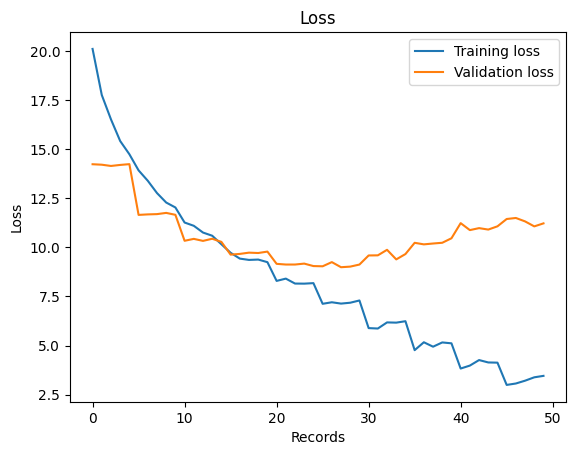

In [30]:
plt.plot(training_loss, label="Training loss")
plt.plot(validation_loss, label="Validation loss")
plt.legend(loc="upper right")
plt.title("Loss")
plt.xlabel("Records")
plt.ylabel("Loss")
plt.show()

(50, 10)


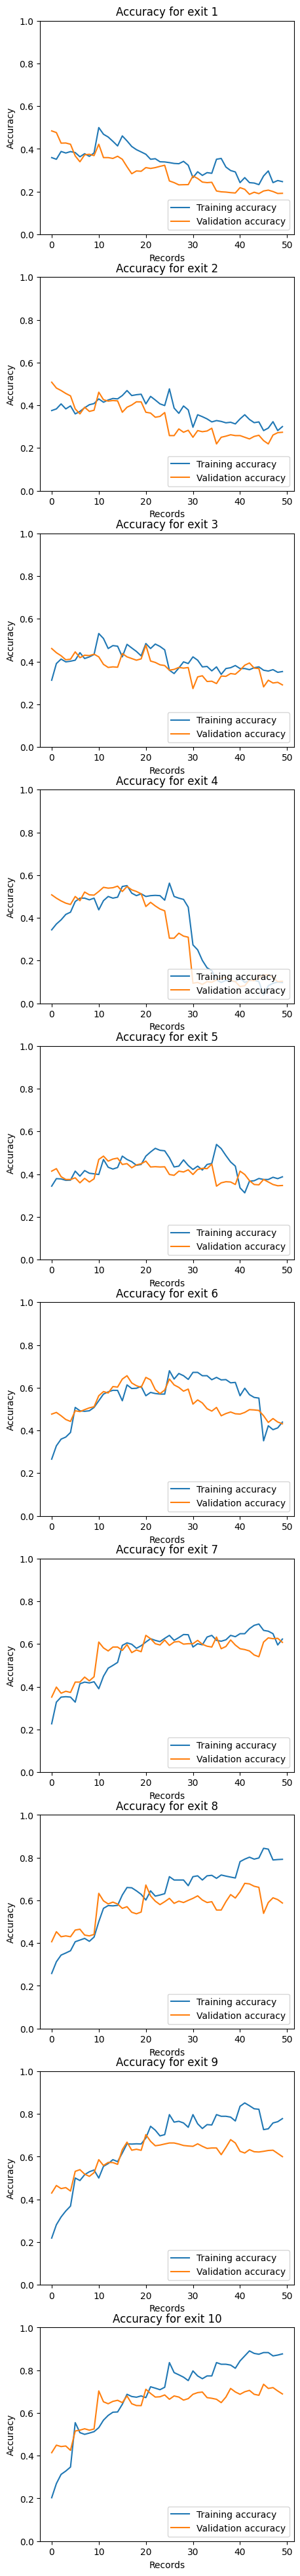

In [31]:
training_accuracy = np.array(training_accuracy)
validation_accuracy = np.array(validation_accuracy)
print(training_accuracy.shape)
fig, axs = plt.subplots(10, 1, figsize=(5, 50))
axs = axs.flatten()
for i in range(10):
    axs[i].plot(training_accuracy[:, i], label="Training accuracy")
    axs[i].plot(validation_accuracy[:, i], label="Validation accuracy")
    axs[i].legend(loc="lower right")
    axs[i].set_title(f"Accuracy for exit {i + 1}")
    axs[i].set_xlabel("Records")
    axs[i].set_ylabel("Accuracy")
    axs[i].set_ylim([0, 1])

### Using a different decision criterion for early exit (probability of the output)

In [32]:
#to check memory usage and gpu status
!nvidia-smi

Mon Nov 20 23:11:14 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   75C    P0    33W /  70W |   2595MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [33]:
class BVGG13_v3(nn.Module):
    def __init__(self, num_classes, batch_norm=False, dropout=False):
        super(BVGG13_v3, self).__init__()
        self.batch_norm = batch_norm
        self.dropout = dropout
        self.set_exit_threshold(0.0)

        self.conv_layers = nn.ModuleList(
            [
                # first block
                nn.Conv2d(3, 64, kernel_size=3, padding=1),
                nn.Conv2d(64, 64, kernel_size=3, padding=1),
                # second block
                nn.Conv2d(64, 128, kernel_size=3, padding=1),
                nn.Conv2d(128, 128, kernel_size=3, padding=1),
                # third block
                nn.Conv2d(128, 256, kernel_size=3, padding=1),
                nn.Conv2d(256, 256, kernel_size=3, padding=1),
                # fourth block
                nn.Conv2d(256, 512, kernel_size=3, padding=1),
                nn.Conv2d(512, 512, kernel_size=3, padding=1),
                # fifth block
                nn.Conv2d(512, 512, kernel_size=3, padding=1),
                nn.Conv2d(512, 512, kernel_size=3, padding=1),
            ]
        )

        self.pool_layers = nn.ModuleList(
            [
                nn.Identity(),
                nn.MaxPool2d(kernel_size=2, stride=2),
                nn.Identity(),
                nn.MaxPool2d(kernel_size=2, stride=2),
                nn.Identity(),
                nn.MaxPool2d(kernel_size=2, stride=2),
                nn.Identity(),
                nn.MaxPool2d(kernel_size=2, stride=2),
                nn.Identity(),
                nn.MaxPool2d(kernel_size=2, stride=2),
            ]
        )

        if self.batch_norm:
            self.norm_layers = nn.ModuleList(
                [
                    nn.BatchNorm2d(64),
                    nn.BatchNorm2d(64),
                    nn.BatchNorm2d(128),
                    nn.BatchNorm2d(128),
                    nn.BatchNorm2d(256),
                    nn.BatchNorm2d(256),
                    nn.BatchNorm2d(512),
                    nn.BatchNorm2d(512),
                    nn.BatchNorm2d(512),
                    nn.BatchNorm2d(512),
                ]
            )
        else:
            self.norm_layers = nn.ModuleList(
                [
                    nn.Identity(),
                    nn.Identity(),
                    nn.Identity(),
                    nn.Identity(),
                    nn.Identity(),
                    nn.Identity(),
                    nn.Identity(),
                    nn.Identity(),
                    nn.Identity(),
                    nn.Identity(),
                ]
            )

        if self.dropout:
            self.classifier = nn.Sequential(
                # 1st block
                nn.Linear(512 * 1 * 1, 4096),
                nn.ReLU(inplace=True),
                nn.Dropout(),
                # 2nd block
                nn.Linear(4096, 4096),
                nn.ReLU(inplace=True),
                nn.Dropout(),
                # output
                nn.Linear(4096, num_classes),
            )
        else:
            self.classifier = nn.Sequential(
                # 1st block
                nn.Linear(512 * 1 * 1, 4096),
                nn.ReLU(inplace=True),
                # 2nd block
                nn.Linear(4096, 4096),
                nn.ReLU(inplace=True),
                # output
                nn.Linear(4096, num_classes),
            )

        self.early_exits = nn.ModuleList(
            [
                create_early_exit(32, 64, num_classes),
                create_early_exit(16, 64, num_classes),
                create_early_exit(16, 128, num_classes),
                create_early_exit(8, 128, num_classes),
                create_early_exit(8, 256, num_classes),
                create_early_exit(4, 256, num_classes),
                create_early_exit(4, 512, num_classes),
                create_early_exit(2, 512, num_classes),
                create_early_exit(2, 512, num_classes),
            ]
        )

    def forward(self, x, inference=False):
        g_functions = []
        out = []
        soft_out = []
        e = 0
        for conv, norm, pool in zip(
            self.conv_layers, self.norm_layers, self.pool_layers
        ):
            x = conv(x)
            x = norm(x)
            F.relu(x, inplace=True)
            x = pool(x)
            if e < len(self.early_exits):
                x_ee = self.early_exits[e](x)
                out.append(x_ee)
                H = find_max_prob(x_ee)
                g_functions.append(H)
                e += 1
                if inference and torch.greater(H, self.exit_threshold):
                    return x_ee, H, e

        # flatten
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        out.append(x)
        last_H = find_max_prob(x)
        if inference:
            return x, last_H, len(soft_out)

        soft_out.append(x)

        k = len(g_functions) - 1
        for i, o in enumerate(out[-2::-1]):
            h = g_functions[k].unsqueeze(1)
            k -= 1
            # print(h.shape)
            # print(o.shape)
            f_tilde = h * o + (1 - h) * soft_out[-1]
            # print("Early exit", i)
            # print(f_tilde.detach().cpu())
            soft_out.append(f_tilde)

        soft_out.reverse()

        return out, soft_out

    def set_exit_threshold(self, exit_threshold):
        self.exit_threshold = torch.tensor(exit_threshold)

In [34]:
torch.manual_seed(42)
bvgg_v3 = BVGG13_v3(num_classes=10)
# print(vgg)
# print(check_train)
# print(check_val)

optimizer = optim.Adam(
    bvgg_v3.parameters(),
    lr=0.0005,
)

loss_fn = JointCrossEntropy()

n_epochs = 30

bvgg_v3.to(device)

start = time.time()
(
    training_loss,
    training_accuracy,
    validation_loss,
    validation_accuracy,
) = train_model_ee_v2(
    bvgg_v3,
    n_epochs,
    dataset_train,
    dataset_valid,
    optimizer,
    loss_fn,
    early_stopping=True,
    verbose=True,
)
end = time.time()
print(f"Training took {end - start:.2f} seconds")

Epoch 1	Training loss: 19.8484	Accuracy: [33.59 41.41 29.69 33.59 31.25 25.78 32.81 21.88 17.19 15.62]
Epoch 1	Training loss: 17.1690	Accuracy: [42.19 44.53 39.45 35.55 38.28 33.98 39.84 30.47 25.39 27.73]
Epoch 1	Training loss: 15.9744	Accuracy: [46.35 46.61 41.93 37.24 38.8  36.2  39.32 33.59 28.39 30.99]
Epoch 1	Training loss: 14.7725	Accuracy: [47.07 48.44 44.14 39.26 40.23 38.09 40.62 35.55 32.42 33.4 ]
Epoch 1	Training loss: 14.0026	Accuracy: [48.91 50.47 46.25 41.72 42.19 40.   42.5  38.44 35.16 36.09]
Epoch 1	Validation loss: 14.1012	Accuracy: [54.69 53.12 52.34 51.56 49.22 45.31 42.19 42.97 38.28 35.94]
Epoch 1	Validation loss: 14.0541	Accuracy: [55.47 55.47 51.95 51.56 51.56 48.83 45.7  45.7  42.19 42.58]
Epoch 1	Validation loss: 14.0172	Accuracy: [52.08 53.65 51.56 50.   50.78 46.88 45.05 46.09 42.45 42.19]
Epoch 1	Validation loss: 13.9885	Accuracy: [52.15 51.95 50.98 48.05 49.22 46.48 45.51 45.7  42.19 42.19]
Epoch 1	Validation loss: 14.1033	Accuracy: [51.56 50.94 50.47 47.

### Test data

In [35]:
# test accuracy
bvgg_v3.eval()

with torch.no_grad():
    for i in range(10):
        correct = 0
        total = 0
        start = time.time()
        for data, target in dataset_test:
            # move tensors to GPU if CUDA is available
            data = data.to(device)
            target = target.to(device)
            # forward pass
            output, soft_output = bvgg_v3(data, inference=False)
            # Test accuracy on the final exit
            _, pred = torch.max(output[i], dim=1)
            correct += (pred == target).sum().item()
            total += target.size(0)
        end = time.time()
        print(f"Exit {i+1} test accuracy: {correct / total * 100:.2f}%")
        print(f"Test took {end - start:.2f} seconds")

avg_acc = correct / total
print(f"the average accuracy is {100*avg_acc}")

Exit 1 test accuracy: 51.94%
Test took 70.43 seconds
Exit 2 test accuracy: 10.44%
Test took 70.11 seconds
Exit 3 test accuracy: 64.09%
Test took 70.13 seconds
Exit 4 test accuracy: 11.24%
Test took 69.06 seconds
Exit 5 test accuracy: 61.41%
Test took 69.61 seconds
Exit 6 test accuracy: 29.02%
Test took 70.10 seconds
Exit 7 test accuracy: 69.90%
Test took 70.92 seconds
Exit 8 test accuracy: 69.56%
Test took 69.99 seconds
Exit 9 test accuracy: 69.85%
Test took 69.63 seconds
Exit 10 test accuracy: 69.59%
Test took 70.20 seconds
the average accuracy is 69.58666666666666


### Inference time

In [36]:
bvgg_v3.eval()
test_iter = iter(dataset_test)
np.random.seed(666)
for i in range(np.random.randint(len(dataset_test))):
    img_batch, target_batch = next(test_iter)
img_idx = np.random.randint(batch_size)
img = img_batch[img_idx]
target = target_batch[img_idx]
img = img.unsqueeze(0).to(device)

bvgg_v3.set_exit_threshold(0.5)
with torch.no_grad():
    start = time.time()
    output, H, e = bvgg_v3(img, inference=True)
    end = time.time()
    print(f"Inference time {end - start:.8f} seconds")
    print(f"Exit: {e+1}")
    print(f"Probability: {H.detach().cpu()}")
    print(f"Output: {output.detach().cpu()}")
    _, pred = torch.max(output, dim=1)
    print(f"Prediction: {classes[pred]}")
    print(f"Target: {classes[target]}")

Inference time 0.00091243 seconds
Exit: 2
Probability: tensor([0.8549])
Output: tensor([[-6.3668, -2.5483,  2.7051,  6.6148,  1.3452,  4.6583, -0.3363, -0.7580,
         -2.8632,  0.0742]])
Prediction: cat
Target: dog


In [37]:
#to check memory usage and gpu status
!nvidia-smi

Mon Nov 20 23:54:01 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   75C    P0    33W /  70W |   2821MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

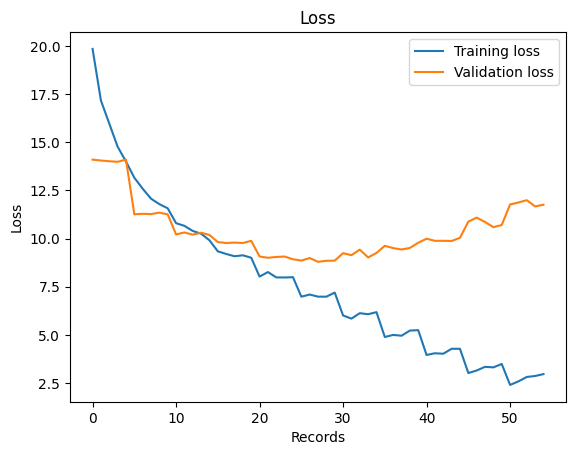

In [38]:
plt.plot(training_loss, label="Training loss")
plt.plot(validation_loss, label="Validation loss")
plt.legend(loc="upper right")
plt.title("Loss")
plt.xlabel("Records")
plt.ylabel("Loss")
plt.show()

(55, 10)


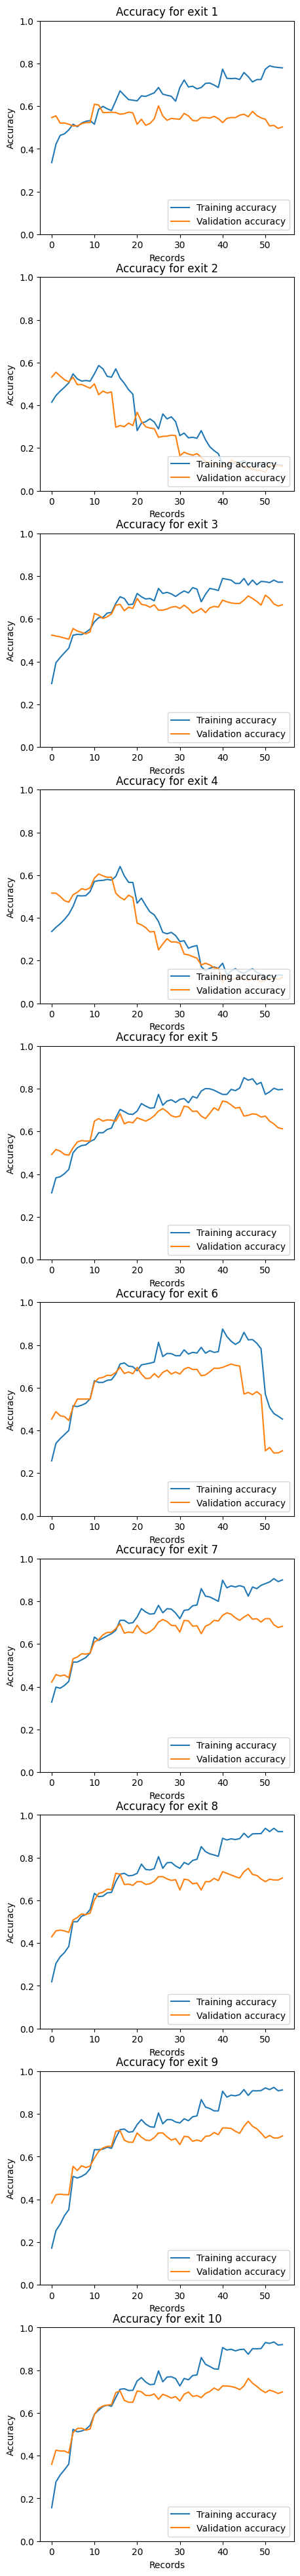

In [39]:
training_accuracy = np.array(training_accuracy)
validation_accuracy = np.array(validation_accuracy)
print(training_accuracy.shape)
fig, axs = plt.subplots(10, 1, figsize=(5, 50))
axs = axs.flatten()
for i in range(10):
    axs[i].plot(training_accuracy[:, i], label="Training accuracy")
    axs[i].plot(validation_accuracy[:, i], label="Validation accuracy")
    axs[i].legend(loc="lower right")
    axs[i].set_title(f"Accuracy for exit {i + 1}")
    axs[i].set_xlabel("Records")
    axs[i].set_ylabel("Accuracy")
    axs[i].set_ylim([0, 1])